#### 1) Apply Bayesian Logistic Regression on the breast cancer dataset from Assignment 1. For faster execution use a subset of the best predictors. Use default GLM priors.

a) Build model and compute following metrics
    
    • Trace plot, credible intervals , MAP estimates , summary metrics 

b) Interpretation and conclusions
    
    • Plot probability of breast cancer (Y axis) against any predictor (X axis)
    • Provide suggestions for informative priors for at least 2 of the input parameters Useful Links : 
    
    https://docs.pymc.io/notebooks/GLM-logistic.html


In [208]:
import networkx as nx
import numpy as np
import pandas as pd
import pymc3 as pm
import pylab as plt
import seaborn as sns

import matplotlib.pyplot as plt

from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel

from pymc3 import Metropolis, NUTS, sample, traceplot

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [125]:

data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)
data.columns = [ 
    'ID', 'Type_of_Cancer', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
data.head(2)

,ID,Type_of_Cancer,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [126]:
x_df = data.drop(['ID', 'Type_of_Cancer'], axis = 1)
x = data.drop(['ID', 'Type_of_Cancer'], axis = 1).values
y = data['Type_of_Cancer']

In [127]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [128]:
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(x, y)
selected = fit.support_
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))


/Users/elssieguerra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/elssieguerra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

Num Features: 3
Selected Features: [False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False  True  True False False]
Feature Ranking: [ 4 11 13 20 23  8  3  6  7 26  1  9  5 18 28 21 12 24 25 27 19 10 17 22
 16  2  1  1 14 15]


/Users/elssieguerra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/elssieguerra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [129]:
x_df.columns[selected]

Index(['radius_se', 'concavity_worst', 'concave_points_worst'], dtype='object')

## I have selected 'radius_SE', 'Concavity_Worst' and 'Concave_points_worst'  for my dataset since these are the main 3 features of my model.


#### 1a) Building the model and computing the metrics

In [217]:
bay_lin_x = data[['radius_se', 'concavity_worst', 'concave_points_worst', 'Type_of_Cancer']]

In [218]:
Cancer_Type = 1 * (bay_lin_x['Type_of_Cancer'] == "M")

In [219]:
bay_lin_x['Type_of_Cancer'] = Cancer_Type

/Users/elssieguerra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


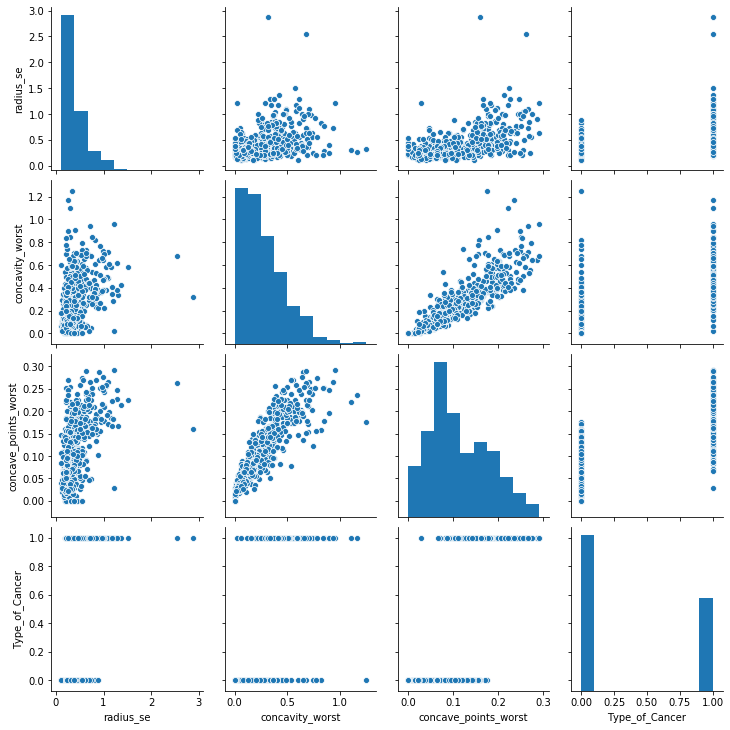

In [220]:
g = sns.pairplot(bay_lin_x)
g

In [222]:
# Printing out counts to validate that we have more Benign breast cancer, than Malign breast cancer.
Cancer_Type.value_counts()

0    357
1    212
Name: Type_of_Cancer, dtype: int64

In [225]:
# Computing the correlation matrix.
corr = bay_lin_x.corr()
corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)

,radius_se,concavity_worst,concave_points_worst,Type_of_Cancer
radius_se,1.00,0.38,0.53,0.57
concavity_worst,0.38,1.00,0.86,0.66
concave_points_worst,0.53,0.86,1.00,0.79
Type_of_Cancer,0.57,0.66,0.79,1.00


#### There seems to ve a strong positive correlation between the type of Cancer and my other 3 variables. 

In [207]:
# I will be using the following formula:
# Type_of_Cancer ~ radius_se + concavity_worst + concave_points_worst 

### We could use sociological knowledge about the effects of concavity_worst, concave_point_worst and radius_se in different types of Breast Cancer, but instead, I will use the default prior specification for GLM coefficients that PyMC3 gives us.

In [232]:

with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('Type_of_Cancer ~ radius_se + concavity_worst + concave_points_worst',
                            bay_lin_x,
                            family = pm.glm.families.Binomial())

    trace = pm.sample(1100, cores = 1, tune = 1000, init = 'adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [concave_points_worst, concavity_worst, radius_se, Intercept]
INFO:pymc3:NUTS: [concave_points_worst, concavity_worst, radius_se, Intercept]

Sampling chain 0, 0 divergences: 100%|██████████| 2100/2100 [00:15<00:00, 137.33it/s]

Sampling chain 1, 0 divergences:  37%|███▋      | 776/2100 [00:05<00:09, 141.35it/s]


Sampling chain 1, 0 divergences: 100%|██████████| 2100/2100 [00:14<00:00, 142.10it/s]


In [233]:
def plot_traces(traces, retain = 0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines = tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i, 0].annotate('{:.2f}'.format(mn), xy = (mn, 0), xycoords = 'data',
                    xytext = (5, 10), textcoords = 'offset points', rotation = 90,
                    va = 'bottom', fontsize = 'large', color = '#AA0022')

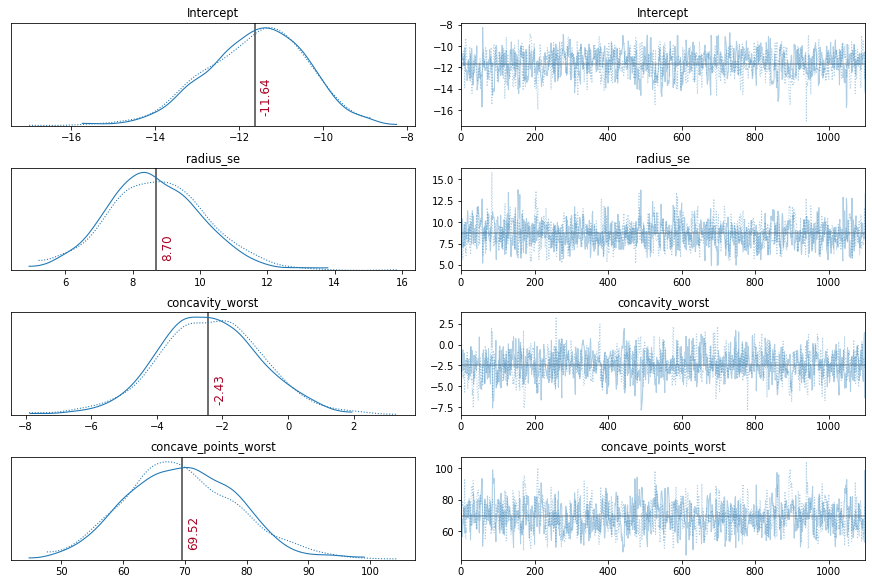

In [234]:
plot_traces(trace);

#### Bayesian Distribution over the parameters radius_se and concavity_worst

<Figure size 648x504 with 0 Axes>

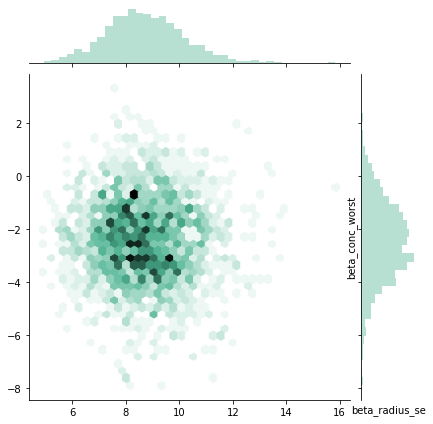

In [236]:
plt.figure(figsize = (9,7))
sns.jointplot(trace['radius_se'], trace['concavity_worst'], kind = "hex", color = "#4CB391")
plt.xlabel("beta_radius_se")
plt.ylabel("beta_conc_worst");

In [246]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [248]:
def lm_full(trace, radius_se, concavity_worst, concave_points_worst):
    shape = np.broadcast(radius_se, concavity_worst, concave_points_worst).shape
    x_norm = np.asarray([np.broadcast_to(x, shape)
                         for x in [radius_se, concavity_worst, concave_points_worst]])

    return 1 / (1 + np.exp(-(trace['Intercept'] +
                             trace['radius_se'] * x_norm[0] +
                             trace['concavity_worst'] * x_norm[1] +
                             trace['concave_points_worst'] * x_norm[2])))

# Linear model with radius_se == 0.25 and concave_points_worse == 0.2
lm = lambda x, samples: lm_full(samples, 0.25, x , 0.2)

# Linear model with radius_se == 0.75 and concave_points_worse == 0.2
lm2 = lambda x, samples: lm_full(samples, 0.5 , x, 0.2)

# Linear model with radius_se == 1.0 and concave_points_worse == 0.2
lm3 = lambda x, samples: lm_full(samples, 1., x, 0.2)

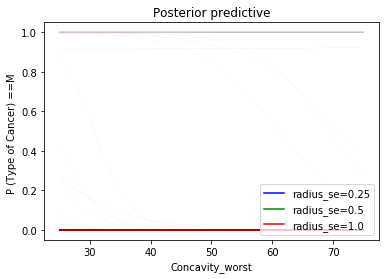

In [250]:
# Plotting the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(trace, eval = np.linspace(25, 75, 1000), 
                                 lm = lm, samples = 100, color = "blue", alpha = .15)

pm.plot_posterior_predictive_glm(trace, eval = np.linspace(25, 75, 1000), 
                                 lm = lm2, samples = 100, color = "green", alpha = .15)

pm.plot_posterior_predictive_glm(trace, eval = np.linspace(25, 75, 1000), 
                                 lm = lm3, samples = 100, color = "red", alpha = .15)

import matplotlib.lines as mlines

blue_line = mlines.Line2D(['lm'], [], color = 'b', label = 'radius_se=0.25')
green_line = mlines.Line2D(['lm2'], [], color = 'g', label = 'radius_se=0.5')
red_line = mlines.Line2D(['lm3'], [], color = 'r', label = 'radius_se=1.0')

plt.legend(handles = [blue_line, green_line, red_line], loc = 'lower right')
plt.ylabel("P (Type of Cancer) ==M ")
plt.xlabel("Concavity_worst")
plt.show()

/Users/elssieguerra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


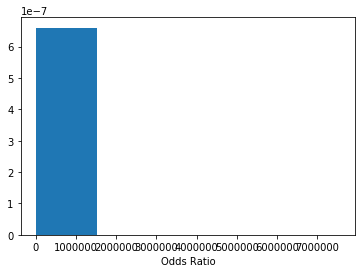

In [256]:

b = trace['radius_se']
plt.hist(np.exp(b), bins = 5, normed = True)
plt.xlabel("Odds Ratio")
plt.show()

In [257]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < O.R. < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(408.148 < O.R. < 116878.795) = 0.95


### We are 95% confident that the odds ratio lies within our interval of (408.148 and 116,878.95)



### 2. Apply a Bayesian change point model on any social, economic or environmental indicator time series data set (air quality, traffic, crime, employment, etc.) starting in Jan 2020.

a) Plot the time series and compare against the Covid-19 data Assignment 3 (expect a lead/lag)

b) Build a Bayesian changepoint model

c) Plot the location and time periods of the changepoints.

d) Summarize your observations with respect to timelines of the Covid-19 lockdown


In [130]:
# Since Panama has a smaller population I did not find enought data to evaluate crime rates. Therefore, I switch to the United States.
# Focusing on Chicago I will find the overall crime rate, and create a plot with it.
US = pd.read_csv('US_COVID19.csv')
US.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Crimes_Chicago
0,NaN,US,37.0902,-95.7129,1/22/20,1,0,0,623
1,NaN,US,37.0902,-95.7129,1/23/20,1,0,0,584
2,NaN,US,37.0902,-95.7129,1/24/20,2,0,0,653
3,NaN,US,37.0902,-95.7129,1/25/20,2,0,0,656
4,NaN,US,37.0902,-95.7129,1/26/20,5,0,0,604


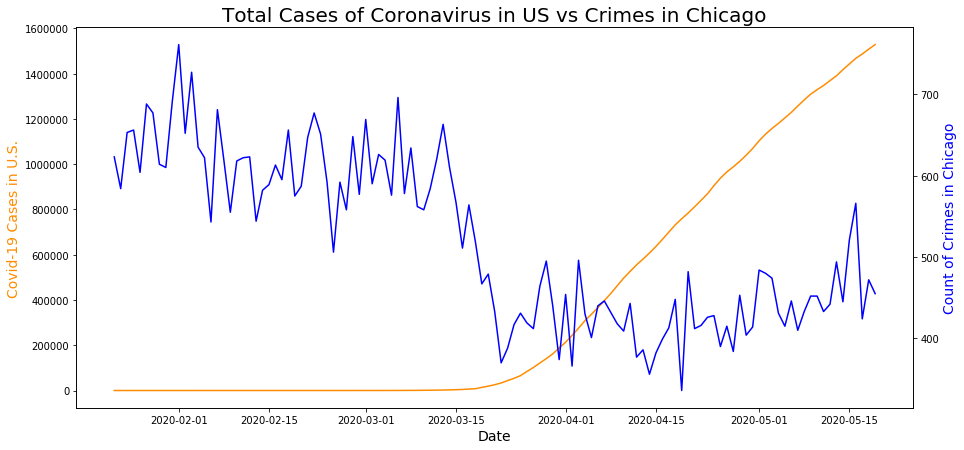

In [131]:
y1 = US['Confirmed']
US['Date'] = pd.to_datetime(US['Date'])
x = US['Date']
y2 = US['Crimes_Chicago']

fig,ax = plt.subplots(figsize = (15,7))

# Making a plot.
ax.plot(x, y1, color = 'darkorange')

# Setting x-axis label.
ax.set_xlabel("Date", fontsize = 14)

# Setting y-axis label
ax.set_ylabel("Covid-19 Cases in U.S.", color = 'darkorange', fontsize = 14)
ax2 = ax.twinx()

# Making another plot with a different y-axis, using the second axis object.
ax2.plot(x, y2, color = "blue")
ax2.set_ylabel("Count of Crimes in Chicago", color = "blue", fontsize = 14)
plt.title("Total Cases of Coronavirus in US vs Crimes in Chicago", fontsize = 20)
plt.show()

### Comment: We can definitely see that while the amount of Coronavirus Cases increase in the U.S., the Crimes in Chicago Area decrease drastically. This is because of the Stay-At-Home Order was effective in Chicago in March 26th, 2020.

### Model

#### Occurrences of crimes in Chicago in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to Covid19 cases.The parameters are defined as follows: 

* $D_t$: The number of crimes at time $t * r_t$. The rate parameter of the Poisson distribution of crimes in time t. 
* $s$: The time in which the rate parameter changes (the switchpoint). 
* $e$: The rate parameter before the switchpoint s. 
* $l$: The rate parameter after the switchpoint s. 
* $t_l, t_h$: The lower and upper boundaries of time t.

$$\begin{split}\begin{aligned}
  D_t &\sim \text{Pois}(r_t), r_t= \begin{cases}
   e, & \text{if } t \le s \\
   l, & \text{if } t \gt s
   \end{cases} \\
  s &\sim \text{Unif}(t_l, t_h)\\
  e &\sim \text{exp}(1)\\
  l &\sim \text{exp}(1)
\end{aligned}\end{split}$$


In [137]:
# Bayesian ChangePoint Model
with pm.Model() as crimes_model:

    # Non-informative prior
    switchpoint = pm.DiscreteUniform('switchpoint', lower = new_x.min(), upper = new_x.max())

    # Priors for pre- and post- switch rates number of disasters.
    # The exponential counting function is always positive.
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocating appropriate Poisson rates to years before and after current year.
    # Switching to the Theano function hsa shown to work like an if statement. 
    # It uses the first argument to switch between the next two arguments.
    rate = pm.math.switch(switchpoint >= new_x, early_rate, late_rate)
    
    #Likelihood function.
    crimes_in_chitown = pm.Poisson('crimes', rate, observed=y2)

In [138]:
# Method 1 - automated.
with crimes_model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:13<00:00, 1548.33draws/s]
The acceptance probability does not match the target. It is 0.8860970890387744, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898866798383918, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [139]:
# Method 2 - NUTS, Metropolis added to the mix.
with crimes_model:
    step1 = NUTS([early_rate, late_rate])

    # Use Metropolis for switchpoint and missing values, since it accommodates discrete variables.
    step2 = Metropolis([switchpoint] )

    trace = sample(10000, step = [step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [late_rate, early_rate]
>Metropolis: [switchpoint]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:12<00:00, 1637.06draws/s]
The acceptance probability does not match the target. It is 0.884908092825691, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


### Results

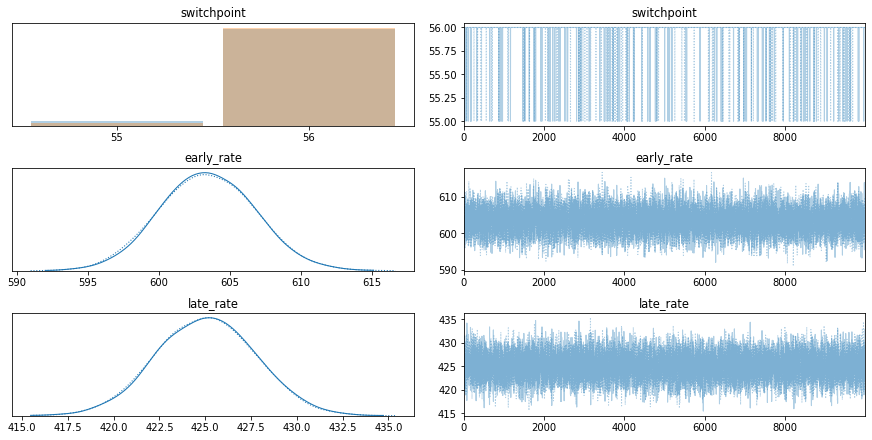

In [140]:
pm.traceplot(trace);

### Visualize SwitchPoint

In [153]:
print(new_x.shape)

print(y2.shape)

(119,)
(119,)


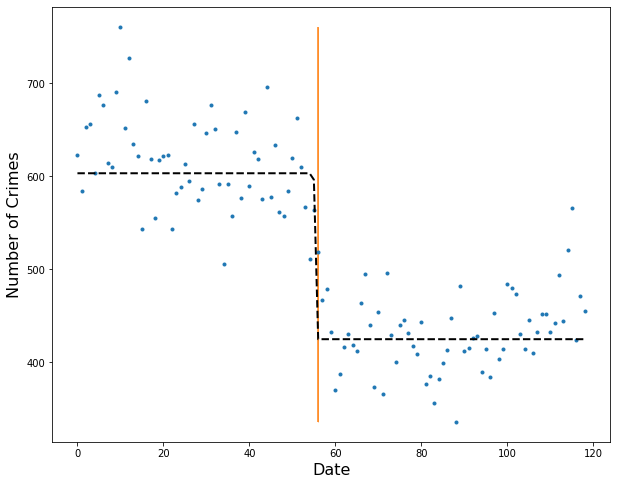

In [156]:
plt.figure(figsize = (10, 8))
plt.plot(new_x, y2, ".")
plt.ylabel("Number of Crimes", fontsize = 16)
plt.xlabel("Date", fontsize = 16)

plt.vlines(trace['switchpoint'].mean(), y2.min(), y2.max(), color = 'C1')
average_crimes = np.zeros_like(y2, dtype = 'float')
for i, new_xs in enumerate(new_x):
    idx = new_xs < trace['switchpoint']
    average_crimes[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])

plt.fill_betweenx(y = [y2.min(), y2.max()], x1 = sp_hpd[0], x2 = sp_hpd[1], alpha = 0.5, color = 'C1');

plt.plot(new_x, average_crimes,  'k--', lw = 2);

In [157]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
switchpoint,55.96,0.19,56.00,56.00,0.00,0.00,3012.0,3012.0,3012.0,20000.0,1.0
early_rate,603.43,3.33,597.16,609.62,0.03,0.02,16566.0,16547.0,16616.0,12377.0,1.0
late_rate,425.05,2.67,420.25,430.24,0.02,0.01,17996.0,17996.0,17977.0,13788.0,1.0


In [166]:
time = pd.DataFrame(x)
print(time[time.index == 56])

         Date
56 2020-03-18


### Comments: We can definitely see a decrease in amount of crimes in Chicago on March 18, since there was an increase in the amount of cases in COVID-19 cases. The switchpoint, then we consider it to be at March 18, which is observation number 56. We can also see that the average amount of crime cases before March 18th is about 603, and after the cases in croonavirus increased and there was more awareness from the Chicagoans, the number of crimes decreased and had an average of 425 crimes. 

### 3) Build a simple Covid-19 health outcome prediction system using a Bayes network. Consider factors such as age, gender, preexisting conditions, chance of hospitalization, etc. Use public data or make assumptions to derive these probabilities.
 a) Exploratory analysis:
 
    • Plot the Bayes network and probability tables
    
    • Find all active trails and local independencies
    
 b) Inference – ask two questions of the diagnostic model for each of the below:
 
    • Causal reasoning. e.g. probability of death for male above 65 yrs with underlying condition
    
    • Evidential reasoning e.g. probability of no underlying condition given healthy discharge

### Answers: For Part a),  I have constructed a Bayes Network, please refer to the picture below

In [170]:
%%html
<img src='pic.png'/>

In [173]:
model = BayesianModel([('age', 'preexisting'), ('gender', 'preexisting'), ('preexisting', 'hospitalization'), ('has_covid', 'hospitalization')])

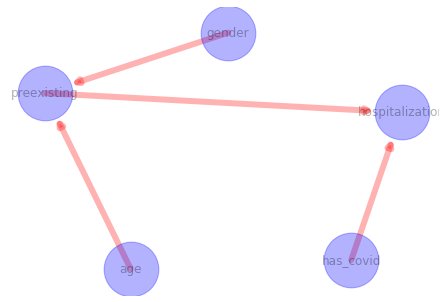

In [174]:
options = {
    'node_color': 'b',
    'node_size': 3000,
    'width': 6,
    'alpha': 0.3,
    'edge_color': 'r'
}

nx.draw(model, with_labels = True, **options)
plt.show()

### Set up the relationships

In [178]:
cpd_age = TabularCPD('age', 2, [[0.8, 0.2]]);
cpd_gen = TabularCPD('gender', 2, [[0.45, 0.55]]);

cpd_pre = TabularCPD('preexisting', 2, [[0.95, 0.98, 0.6, 0.7], [0.05, 0.02, 0.40, 0.3]],
                     evidence = ['age', 'gender'], evidence_card = [2, 2]);

cpd_has_covid = TabularCPD('has_covid', 2, [[0.006, 0.994]]);

cpd_hosp = TabularCPD('hospitalization', 2, [[0.98, 0.8, 0.9, 0.6], [0.02, 0.2, 0.1, 0.4]],
                      evidence = ['preexisting', 'has_covid'], evidence_card = [2,2]);

In [179]:
model.add_cpds(cpd_age, cpd_gen, cpd_pre, cpd_has_covid, cpd_hosp)

### Structure of the Graph

In [177]:
model.get_cpds()

[<TabularCPD representing P(age:2) at 0x1a23873810>,
 <TabularCPD representing P(gender:2) at 0x1a23873690>,
 <TabularCPD representing P(preexisting:2 | age:2, gender:2) at 0x1a23f22fd0>,
 <TabularCPD representing P(has_covid:2) at 0x1a23873ad0>,
 <TabularCPD representing P(hospitalization:2 | preexisting:2, has_covid:2) at 0x1a23873250>]

### 1b) These are the active Trails for each of the variables

In [180]:
model.active_trail_nodes('hospitalization')

{'hospitalization': {'age',
  'gender',
  'has_covid',
  'hospitalization',
  'preexisting'}}

In [181]:
model.active_trail_nodes('preexisting')

{'preexisting': {'age', 'gender', 'hospitalization', 'preexisting'}}

In [182]:
model.active_trail_nodes('has_covid')

{'has_covid': {'has_covid', 'hospitalization'}}

In [183]:
model.active_trail_nodes('gender')

{'gender': {'gender', 'hospitalization', 'preexisting'}}

In [184]:
model.active_trail_nodes('age')

{'age': {'age', 'hospitalization', 'preexisting'}}

### Finding the Local Independencies

In [185]:
model.local_independencies('hospitalization')

(hospitalization _|_ gender, age | has_covid, preexisting)

In [186]:
model.local_independencies('preexisting')

(preexisting _|_ has_covid | gender, age)

In [187]:
model.local_independencies('has_covid')

(has_covid _|_ gender, age, preexisting)

In [188]:
model.local_independencies('gender')

(gender _|_ has_covid, age)

In [189]:
model.local_independencies('age')

(age _|_ gender, has_covid)

### 2a) Causal Reasoning

In [192]:
infer = VariableElimination(model)

In [193]:
prob_hospitalization_has_covid = infer.query(variables = ['hospitalization'], evidence = {'has_covid': 1})
print(prob_hospitalization_has_covid)

Eliminating: preexisting: 100%|██████████| 3/3 [00:00<00:00, 358.85it/s]

+--------------------+------------------------+
| hospitalization    |   phi(hospitalization) |
+====================+========================+
| hospitalization(0) |                 0.7808 |
+--------------------+------------------------+
| hospitalization(1) |                 0.2192 |
+--------------------+------------------------+


#### The probability of getting hospitalized, given that you have coronavirus is0.2192

In [198]:
prob_hospitalization_preexistence_age65 = infer.query(variables = ['hospitalization'], 
                                                      evidence = {'age': 1, 'preexisting': 1})

print(prob_hospitalization_preexistence_age65 )

Eliminating: has_covid: 100%|██████████| 2/2 [00:00<00:00, 472.38it/s]

+--------------------+------------------------+
| hospitalization    |   phi(hospitalization) |
+====================+========================+
| hospitalization(0) |                 0.6018 |
+--------------------+------------------------+
| hospitalization(1) |                 0.3982 |
+--------------------+------------------------+


#### The probability of getting hospitalized, give that you are age 65 and have pre-existing conditions is39.82%

### 2b)Evidential Reasoning

In [199]:
prob_age65more_if_hospitalized = infer.query(variables = ['age'], evidence = {'hospitalization': 1})

print(prob_age65more_if_hospitalized )

Eliminating: preexisting: 100%|██████████| 3/3 [00:00<00:00, 312.83it/s]

+--------+------------+
| age    |   phi(age) |
+========+============+
| age(0) |     0.7544 |
+--------+------------+
| age(1) |     0.2456 |
+--------+------------+


#### Given that the person is hospitalized, the probability of person being age 65+, it's 24.56%.

In [200]:
prob_age65more_if_has_preexisting_and_hospitalized  = infer.query(
    variables = ['age'], 
    evidence = {'preexisting': 1, 'hospitalization' : 1})

print(prob_age65more_if_has_preexisting_and_hospitalized)

Eliminating: has_covid: 100%|██████████| 2/2 [00:00<00:00, 229.72it/s]

+--------+------------+
| age    |   phi(age) |
+========+============+
| age(0) |     0.2797 |
+--------+------------+
| age(1) |     0.7203 |
+--------+------------+


#### Given that the person has preexisting conditions, and it is hospitalized, the probability that the person is age 65+, os 72.03%